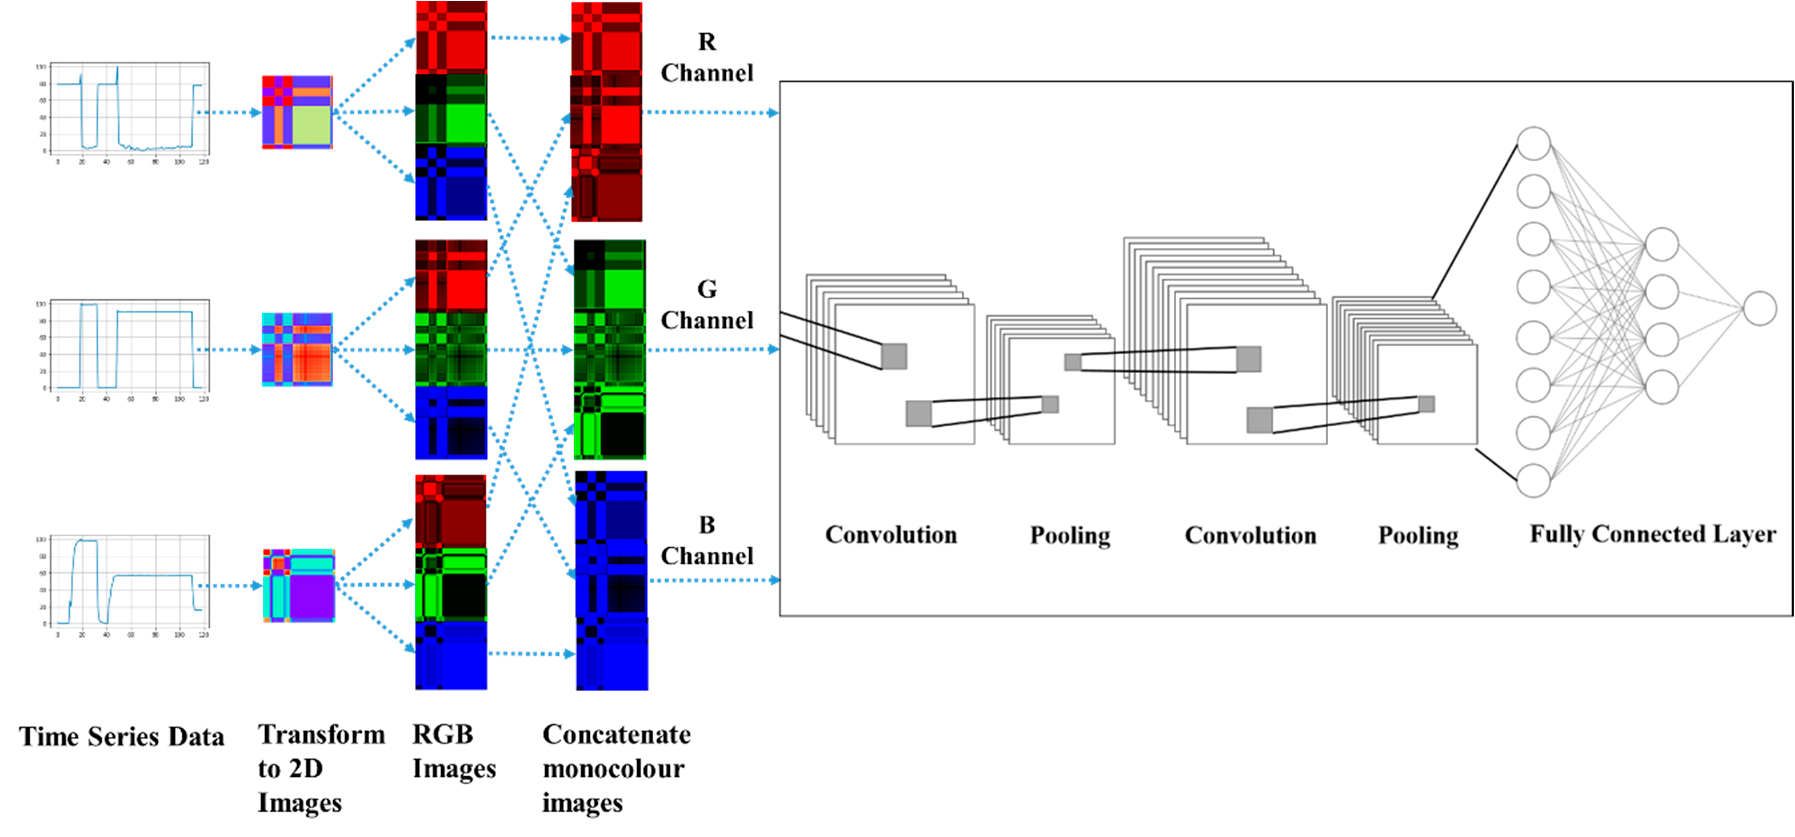

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[66]:


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot
from pyts.approximation import PiecewiseAggregateApproximation
import pandas as pd
import glob
from tqdm.auto import tqdm
import pathlib
import cv2
import numpy as np
# import tensorflow as tf


# In[ ]:


# def GAF(X):
#     X = np.reshape(X,(1,-1))
#     # Transform the time series into Gramian Angular Fields
#     gasf = GramianAngularField(image_size=21, method='summation')
#     X_gasf = gasf.fit_transform(X)
#     gadf = GramianAngularField(image_size=21, method='difference')
#     X_gadf = gadf.fit_transform(X)

#https://pyts.readthedocs.io/en/stable/generated/pyts.image.GramianAngularField.html#pyts.image.GramianAngularField    


def approximate_ts(X, window_size):
    paa = PiecewiseAggregateApproximation(window_size=window_size)
    X_paa = paa.transform(X)
    return X_paa



def timeSeriesToImage(ts, size_x = None, kind = "GADF", window_size = 0):
    if window_size != 0:
        ts = approximate_ts(ts.reshape(1, -1) , window_size)
        ts = ts.reshape(-1,1)
    gasf = GramianAngularField(method='summation')
    gadf = GramianAngularField(method='difference')
    mtf = MarkovTransitionField()
    rp = RecurrencePlot()

    rp = RecurrencePlot()

    if kind == "GADF":
        img = gadf.fit_transform(pd.DataFrame(ts).T)[0]
    elif kind == "GASF":
        img = gasf.fit_transform(pd.DataFrame(ts).T)[0]
    elif kind == "MTF":
        img = mtf.fit_transform(pd.DataFrame(ts).T)[0]
#         img = transformer.transform(ts)
    elif kind == "RP":
        img = rp.fit_transform(pd.DataFrame(ts).T)[0]
#         img = transformer.transform(ts)
    elif kind == "RGB_GAF":
        gasf_img = gasf.transform(pd.DataFrame(ts).T)[0]
        gadf_img = gadf.transform(pd.DataFrame(ts).T)[0]
        img = np.dstack((gasf_img,gadf_img,np.zeros(gadf_img.shape)))
    elif kind == "GASF_MTF":
        gasf_img = gasf.transform(pd.DataFrame(ts).T)[0]
        mtf_img = mtf.fit_transform(pd.DataFrame(ts).T)[0]
        
        img = np.dstack((gasf_img,mtf_img, np.zeros(gasf_img.shape)))
    elif kind == "GADF_MTF":
        gadf_img = gadf.transform(pd.DataFrame(ts).T)[0]
        mtf_img = mtf.fit_transform(pd.DataFrame(ts).T)[0]
        img = np.dstack((gadf_img,mtf_img, np.zeros(gadf_img.shape)))
    return img

def pad_split_chuncks(df, chunk_size = 600, pad = False):
    def split_dataframe(df, chunk_size = 600): 
        chunks = list()
        num_chunks = len(df) // chunk_size + 1
        for i in range(num_chunks):
            chunks.append(df[i*chunk_size:(i+1)*chunk_size])
        return chunks
    
    df_min_max_scaled = df.copy()
#     for column in df_min_max_scaled.columns:
#         df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    

    if pad:
        cur_len = len(df)
        num_pads = chunk_size - (cur_len%chunk_size)
        d = pd.DataFrame(np.zeros((num_pads, len(df.columns))), columns=df.columns)
#         df = df.append(pd.Series(0, index=df.columns), ignore_index=True)
        df = pd.concat([df_min_max_scaled, d], axis=0)
    parts = split_dataframe(df, chunk_size=chunk_size)
    return parts[0:-1]

# def create_gaf(ts, size_x = None):
#     """
#     :param ts:
#     :return:
#     """
#     data = dict()
#     if size_x is None:
#         size_x = ts.shape[0]
        
#     gadf = GramianAngularField(method='difference', image_size=size_x)
# #     data['gadf'] = gadf.fit_transform(pd.DataFrame(ts).T)[0] # ts.T)
# #     return data
#     return gadf.fit_transform(pd.DataFrame(ts).T)[0] # ts.T)

# def split_signal(sig, n_samples, length):
#     """Split a signal into non-overlapping chunks.

#     Parameters
#     ----------
#     sig : 1d array
#         Time series.
#     n_samples : int
#         The chunk size to split the signal into, in samples.

#     Returns
#     -------
#     chunks : 2d array
#         The signal, split into chunks, with shape [n_chunks, chunk_size].

#     Notes
#     -----
#     If the signal does not divide evenly into the number of chunks, this approach
#     will truncate the signal, returning the maximum number of chunks, and dropping
#     any leftover samples.
#     """

#     n_chunks = int(np.floor(len(sig) / float(n_samples)))
#     chunks = np.reshape(sig[:int(n_chunks * n_samples)], (n_chunks, int(n_samples)))
#     res = []
#     for i, v in enumerate(chunks):
#         res.append(tf.keras.preprocessing.sequence.pad_sequences([chunks[i]], maxlen = length, padding='post'))
#     return np.array(res) 


# In[242]:


def convert_ts_to_images(DATASET_FILE, kind, features, minVal, window_size, saveTo):
    files = glob.glob(DATASET_FILE + "*.csv")
    total = 0
    for f in files:
        pathlib.Path(DATASET_FILE  + kind + "/"+ pathlib.Path(f).stem).mkdir(parents=True, exist_ok=True)
        df = pd.read_csv(f, index_col = False, usecols = features)
        parts = [pad_split_chuncks(df.copy(), chunk_size = minVal, pad = True)[0]]
        for i, p in enumerate(parts):
            for feat in p.columns:
                # img = create_gaf(np.array(p[feat].values))
                img = timeSeriesToImage(np.array(p[feat].values), size_x =  None, kind = kind, window_size = window_size)
                pathlib.Path(saveTo+kind+"/"+ pathlib.Path(f).stem).mkdir(parents=True, exist_ok=True)
                cv2.imwrite(saveTo+kind+"/"+ pathlib.Path(f).stem +"/" + feat+ "_part"+ str(i) + ".png", img*255)
                total += 1
    print(total)



In [2]:
features = ["c0_left", "c1_left", "axis_major_left", "axis_minor_left", "area", "c0_right", "c1_right", "axis_major_right", "axis_minor_right", "area.1"]
#features = ["c0_left", "c1_left", "area", "c0_right", "c1_right", "area.1"]

#wanted_results ={500:[40, 50, 60, 70, 80, 90, 100], 750:[40, 50, 60, 70, 80, 90, 100]}
wanted_results ={500:[100], 750:[100]}
'''
for  k, v in wanted_results.items():
    for wsize in v:
        print(f"Generating: {k} * {wsize}")
        to = f'../Data/DataSet/dataFiles/all/{k}/{wsize}/'
        x = k//wsize
        #convert_ts_to_images("../Data/DataSet/dataFiles/", "GASF", features, k, x, to)
        #convert_ts_to_images("../Data/DataSet/dataFiles/", "GADF", features, k, x, to)
        #convert_ts_to_images("../Data/DataSet/dataFiles/", "MTF", features, k, x, to)
        #convert_ts_to_images("../Data/DataSet/dataFiles/", "RP", features, k, x, to)
        convert_ts_to_images("../Data/DataSet/dataFiles/", "RGB_GAF", features, k, x, to)
        convert_ts_to_images("../Data/DataSet/dataFiles/", "GASF_MTF", features, k, x, to)
        convert_ts_to_images("../Data/DataSet/dataFiles/", "GADF_MTF", features, k, x, to)  
        
'''
  
  
"""  
convert_ts_to_images("../Data/DataSet/dataFiles/", "GASF", features, 500)
convert_ts_to_images("../Data/DataSet/dataFiles/", "GADF", features, 500)
convert_ts_to_images("../Data/DataSet/dataFiles/", "MTF", features, 500)
convert_ts_to_images("../Data/DataSet/dataFiles/", "RP", features, 500)
"""


'  \nconvert_ts_to_images("../Data/DataSet/dataFiles/", "GASF", features, 500)\nconvert_ts_to_images("../Data/DataSet/dataFiles/", "GADF", features, 500)\nconvert_ts_to_images("../Data/DataSet/dataFiles/", "MTF", features, 500)\nconvert_ts_to_images("../Data/DataSet/dataFiles/", "RP", features, 500)\n'

C:\Users\Moham\AppData\Local\Programs\Python\Python310\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0 1 2 3 4 5]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
C:\Users\Moham\AppData\Local\Programs\Python\Python310\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0 1 2 3 4 5]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
C:\Users\Moham\AppData\Local\Programs\Python\Python310\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [1]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins wil

(101, 101, 3)


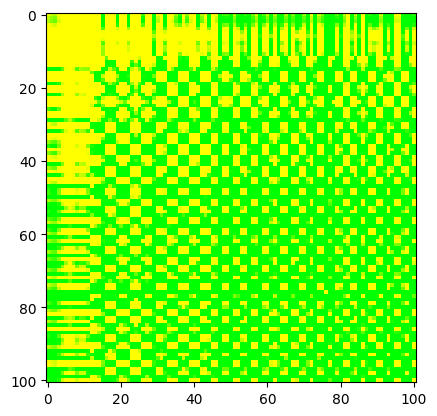

In [21]:
# def get_one(df, kind):
#     images = []
#     img1 = np.zeros((101, 101, 3))
#     for X in df.columns[1:]:
#         data = np.array(df[X].values)
# #         print(data)
#         img = timeSeriesToImage(data, size_x =  None, kind = "GASF_MTF", window_size = len(data)//100)
#         images.append(img)
#         img1 += img
# #         cscs
    
#     print(img1.shape)
#     plt.imshow(img1)

# df = pd.read_csv("HC_1_Gaze test_M_56__years.csv", index_col = False)#, usecols = "c0_left")
# get_one(df, "")
# # df
# # plt.imshow(img)
# # img.shape


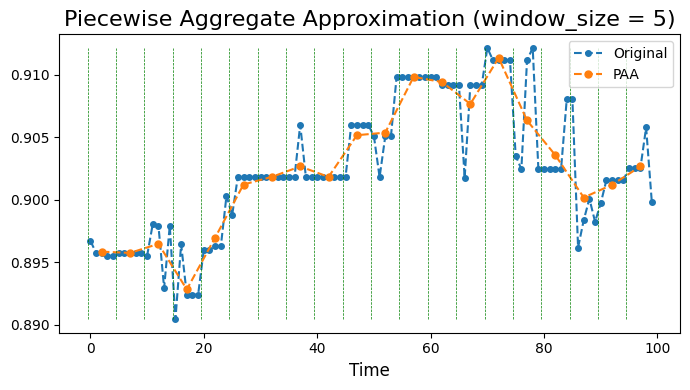

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


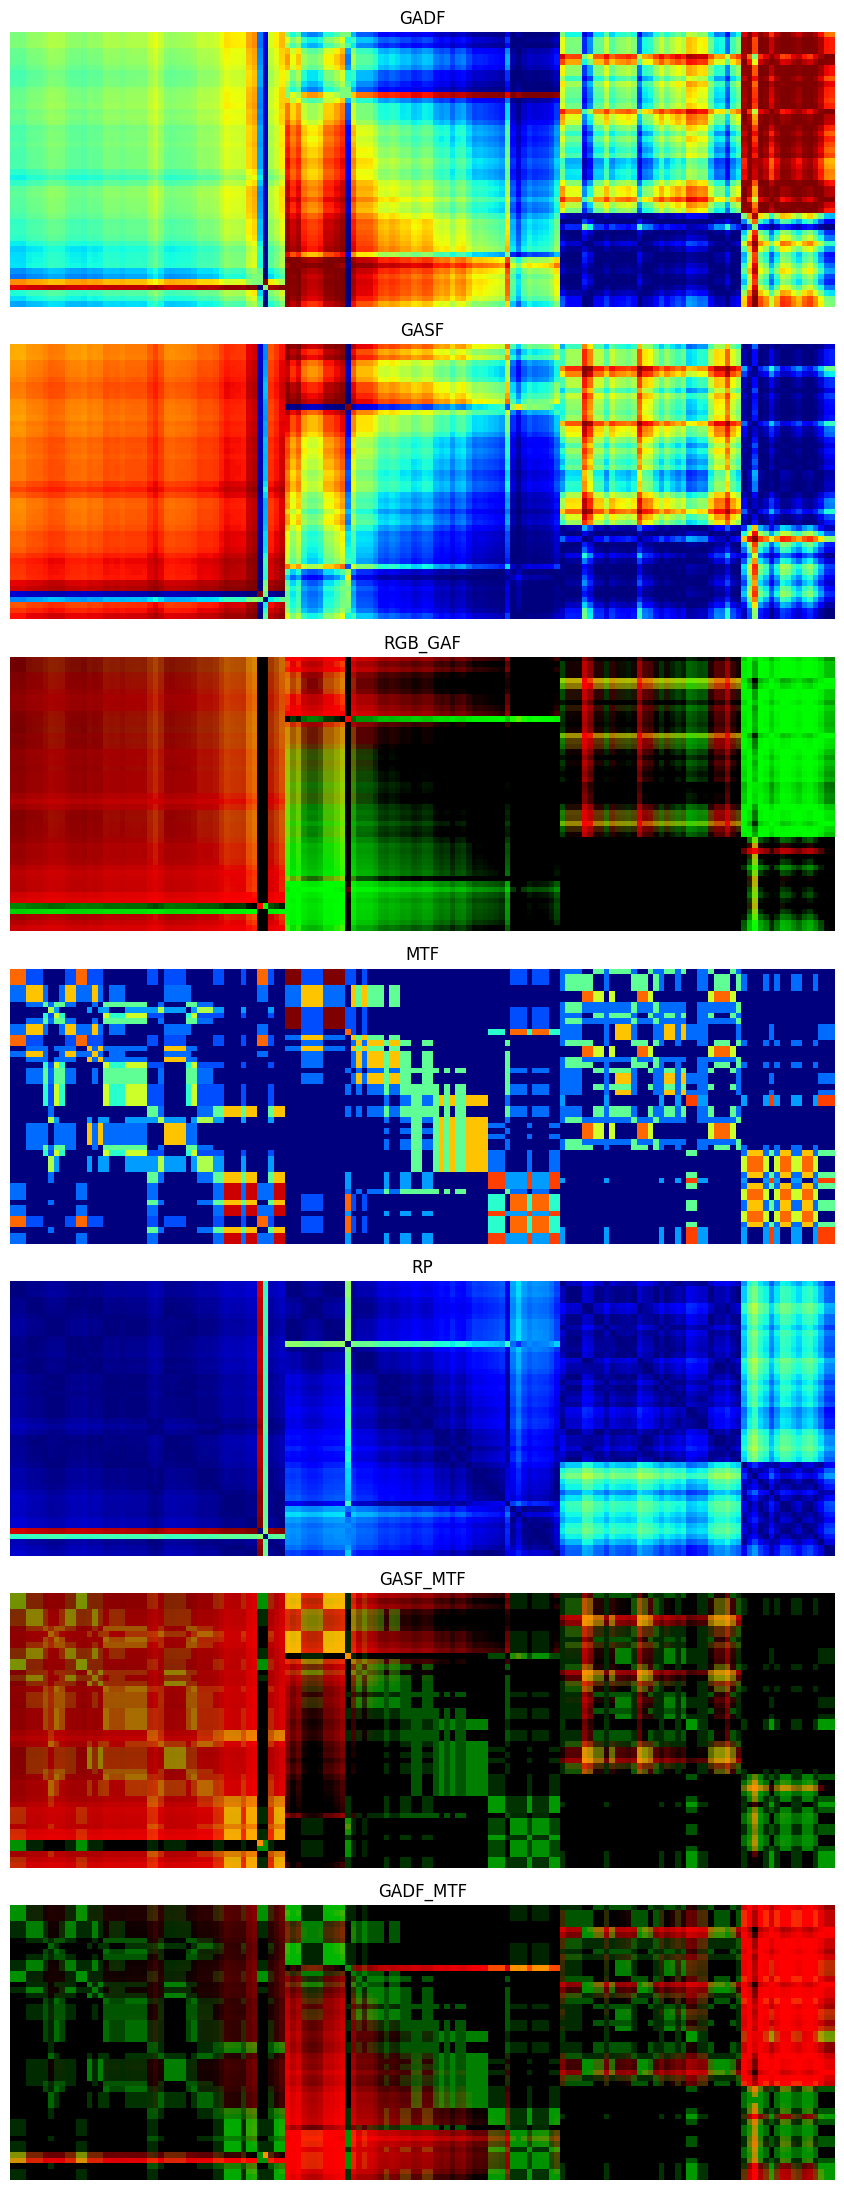

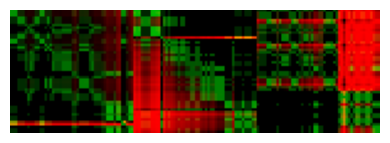

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyts.approximation import PiecewiseAggregateApproximation


pathlib.Path(f'results/').mkdir(parents=True, exist_ok=True)#metrics


# Parameters

# Toy dataset
# rng = np.random.RandomState(41)
# X = rng.randn(n_samples, n_timestamps)

signals = r"F:\Universities\SK\Master\Master_SK\Report_Term4\Report\code\Data\DataSet\dataFiles\HC_26_Spontaneous nystagmus_F_54__years_part340.csv"

df = pd.read_csv(signals, index_col = False)#, usecols = "c0_left")
X = np.array(df.iloc[0:100]["c0_left"].tolist()).reshape(1,-1)

n_samples, n_timestamps = 1, X.shape[1]

# PAA transformation
window_size = 5
paa = PiecewiseAggregateApproximation(window_size=window_size)
X_paa = paa.transform(X)

# Show the results for the first time series

fig = plt.figure(figsize=(7, 4),  tight_layout=True)
plt.plot(X[0], 'o--', ms=4, label='Original')
plt.plot(np.arange(window_size // 2,
                   n_timestamps + window_size // 2,
                   window_size), X_paa[0], 'o--', ms=5, label='PAA')
plt.vlines(np.arange(0, n_timestamps, window_size) - 0.5, X[0].min(), X[0].max(), color='g', linestyles='--', linewidth=0.5)
plt.legend(loc='best', fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.title(f'Piecewise Aggregate Approximation (window_size = {window_size})', fontsize=16)
fig.savefig("results/TSI_PPA.png")
plt.show()



signals = [
    "..\Data\DataSet\dataFiles\HC_26_Spontaneous nystagmus_F_54__years_part340.csv",
    "..\Data\DataSet\dataFiles\PD_m30_Saccade_F_0__years_part84.csv",
    "..\Data\DataSet\dataFiles\PSP_11_Saccade_M_68_4_years_part563.csv",
]




methods = ["GADF", "GASF", "RGB_GAF", "MTF", "RP", "GASF_MTF","GADF_MTF"]

fig, ax = plt.subplots(len(methods), 1, figsize = (10,22),  tight_layout=True)
fig1, ax1 = plt.subplots(1, 1,  figsize = (4,1.6), tight_layout=True)

method_output = []
for i, m in enumerate(methods):
    method_images = []
    for idx, s in enumerate(signals):
        df = pd.read_csv(s, index_col = False)#, usecols = "c0_left")
        X = np.array(df.iloc[0:400]["c0_left"].tolist()).reshape(1,-1)
        img = timeSeriesToImage(X, size_x =  None, kind = m, window_size = len(X[0])//50)
#         ax1.imshow(img, cmap='jet')
#         ax1.axis("off")
#         fig.savefig(f"results/{m}_{idx}.png")
        method_images.append(img)
    img = np.concatenate(method_images, axis = 1)
    ax1.imshow(img, cmap='jet')
    ax1.axis("off")
    fig1.savefig(f"results/{m}.png")
        
    ax[i].imshow(img, cmap='jet')
    ax[i].axis("off")
    ax[i].set_title(m)

fig.savefig("results/TSI_algs.png")
#     plt.figure()
#     plt.title(m)
#     plt.imshow(img, cmap='jet');
#     plt.axis("off")
#     method_output.append(img)
# result = np.concatenate(method_output, axis = 0) 

# plt.imshow(result, cmap='jet');
# plt.axis('off')


In [4]:
# from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
# plt.style.use("ggplot")
# # import seaborn as sns
# # sns.set_style("dark")
# df = pd.read_csv('results_all_models.csv', index_col=False,sep=",")
# df = np.round(df,4)
# df["experiment"] = df["model_name"].apply(lambda x: " ".join(x.split("_")[0:2]))
# # fig, ax1 = plt.subplots(1, 1, figsize=size, tight_layout=True)   
# print(set(df["experiment"]))


# cols = {
#     'batch size' : ["batch_size", "The effect of batch size on model performance"],
#     'features effect' : ["features", "The effect of selected pupil features on model performance"],
#     'image size' : ["SIZE", "The effect of generated image size from TSI on model performance"],
#     "length" : ["length", "The effect of batch size on model performance"],
#     'test effect' : ["Tests", "The effect of selected tests on model performance"],
#     "imgAlg" : ["imgAlg", "The effect of selected TSI algorithm on model performance"]
# }
# DIMS = (10,5)
# width = 0.8
# for exp in set(df["experiment"]):
#     fig, ax = plt.subplots(1,1,figsize=(10,5), tight_layout=True)
#     df1 = df[df["experiment"] == exp]
#     c = ["CategoricalAccuracy", "loss", "precision", "recall"]
#     c.append(cols[exp][0])
#     tmp = df1[c]
# #     print(tmp)
#     print("________________")
# #     if exp == "features effect":
# # #         tmp1 = tmp[~tmp.features.str.get(0).isin(['_'])]
# # #         tmp2 = tmp[tmp.features.str.get(0).isin(['_'])]
# # #         tmp1.plot(x = cols[exp][0], kind='bar', stacked=False, title=f'{cols[exp][1]}(right eye)',ax = ax);
# # #         plt.ylim([0,2])
# # #         plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), ncol=4, fancybox=True, shadow=True, framealpha = 1)
# # #         fig, ax = plt.subplots(1,1,figsize = DIMS)
# # #         tmp2.plot(x = cols[exp][0], kind='bar', stacked=False, title=f'{cols[exp][1]}(left eye)', ax = ax);
        
# #         tmp.plot(x = cols[exp][0], kind='bar', stacked=False, title=f'{cols[exp][1]}(left and right eye)', ax = ax, width=width);        
# # #         plt.ylim([0,ax.get_ylim()[1]+0.1])
# #         plt.xlim([0,ax.get_xlim()[1]+0.2])
# #         plt.legend(loc='upper center', bbox_to_anchor=(0.89, 1), ncol=1, fancybox=True, shadow=True, framealpha = 1)
# #     else:
# #         tmp.plot(x = cols[exp][0],
# #         kind='barh',
# #         stacked=False,
# #         title=f'{cols[exp][1]}',
# #         ax = ax,
# #         width=width,
# #         linewidth = 2);
# #         plt.legend(loc='upper center', bbox_to_anchor=(0.89, 1), ncol=1, fancybox=True, shadow=True, framealpha = 1)
# #         plt.xlim([0,ax.get_xlim()[1]+0.2])
# # #         plt.ylim([ax.get_ylim()[1]+0.1, 0])
# # #     ax.bar_label(ax)
    
# #     ax.xaxis.set_major_locator(MultipleLocator(0.1))
# #     ax.yaxis.set_major_locator(MultipleLocator(0.1))
# #     ax.grid(which='major', color='#CCAACC', linestyle='--', alpha=0.5)
# #     ax.grid(which='minor', color='#CCCC', linestyle=':', alpha=0.5)
# # #     ax.containers
# #     for bars in ax.containers:
# #         ax.bar_label(bars, padding = 4)
# #     fig.savefig(f"results/{exp}_compare", dpi=300, format='png', bbox_inches='tight')


In [5]:
# df[df["experiment"] == "image size"]

In [6]:
# x = {'loss': 1.0973451137542725, 'CategoricalAccuracy': 0.3888888955116272, 'precision': 0.0, 'recall': 0.0, 'prc': 0.3620572090148926, 'precision0': 0.0, 'precision1': 0.0, 'precision2': 0.0, 'recall0': 0.0, 'recall1': 0.0, 'recall2': 0.0, 'model_arch': 'CNN', 'model_name': 'image_size_effect_40_27_02_2023_12_04_22_rowId0', 'Epochs': 2, 'lr': 0.0, 'batch_size': 128, 'SIZE': 42, 'Tests': 'N', 'features': 'XY', 'imgAlg': 'GASF'}
# # pd.DataFrame([x])
# pd.Series(x).to_frame()


In [7]:
# DIMS = (10,5)
# width = 0.9
# for y in list(set(df["experiment"])):
#     cols = {
#     'batch size' : ["batch_size", "The effect of batch size on model performance"],
#     'features effect' : ["features", "The effect of selected pupil features on model performance"],
#     'image size' : ["SIZE", "The effect of generated image size from TSI on model performance"],
#     "length" : ["length", "The effect of batch size on model performance"],
#     'test effect' : ["Tests", "The effect of selected tests on model performance"],
#     "imgAlg" : ["imgAlg", "The effect of selected TSI algorithm on model performance"]
# }
#     x = cols[y][0]
#     fig, ax = plt.subplots(1,1,figsize=(8,10), tight_layout=True)
#     tmp = df[df["experiment"] == y][["Acc", "loss", "precision", "recall", cols[y][0]]]
# #     print(tmp.shape)
#     if y == "batch size":
#         tmp = tmp[0:7]
#     metric_num = (tmp.shape[1]-1)
# #     print(metric_num)
#     tmp.plot(x = x, kind='barh', stacked=False, title=f'', ax = ax, width=width, linewidth = 1);

#     plt.xlim([0,ax.get_xlim()[1]+0.2])
#     ax.xaxis.set_major_locator(MultipleLocator(0.1))
#     ax.yaxis.set_major_locator(MultipleLocator(0.1))
#     ax.grid(which='major', color='#CCAACC', linestyle='--', alpha=0.5)
#     ax.grid(which='minor', color='#CCCC', linestyle=':', alpha=0.5)
#     for bars in ax.containers:
#         ax.bar_label(bars, padding = 5)
#     fig.savefig(f"results/{x}_compare", dpi=300, format='png', bbox_inches='tight')
    
#     y_all =[]
#     for patch in ax.patches:
#         b= patch.get_bbox()
#         y_value=b.x1-b.x0
#         y_all.append(y_value)
#     reshaped = np.array(y_all).reshape((metric_num, -1))
#     maxVals = np.argmax(reshaped, axis = 1)
#     maxVals[1] = np.argmin(reshaped[1,:], axis = 0)
# #     print(reshaped)
# #     print(maxVals, tmp.shape[1])
# #     bestIdx = ((len(y_all)//(tmp.shape[1])) - maxVals)*4 + range(1,5)
#     bestIdx = maxVals + tmp.shape[0]*np.arange(metric_num)
#     idx = np.arange(len(y_all)).reshape((metric_num, -1))
# #     print(idx)
# #     print(idx[0,2])
#     patches = ax.patches
# #     print(len(patches))
# #     for i, v in enumerate(patches):
# #         print(v)
# #         b = v.get_bbox()
# #         ax.text(b.x1+0.08,b.y0 + 0.03, str(i), color='red', fontweight='bold')

#     for i, v in enumerate(bestIdx):
#         b = patches[v].get_bbox()
#         ax.text(b.x1+0.15,b.y0 + 0.01, "*", color='red', fontweight='bold')
#     ax.set_yticks(range(tmp.shape[0]))
# #     ax.set_xticks(range(3))
# #     plt.xlim([0,ax.get_xlim()[1]+0.2])
#     plt.xlim([0,ax.get_xlim()[1]+0.01])
#     plt.legend(loc='upper center', bbox_to_anchor=(1-0.1, 1), ncol=1, fancybox=True, shadow=True, framealpha = 1)
# #     print(ax.get_xlim())
#     fig.savefig(f"results/{x}_compare.png", dpi=300, format='png', bbox_inches='tight')

    
    


In [151]:
# t  = df[df["experiment"] == "test effect"][["precision0", "precision1", "precision2", "recall0", "recall1", "recall2", "Tests"]]
def plotGategoriesResults(df, cols1, criteria_col, title = "", DIMS = (8,10), width = 0.9, shiftLegend = (0.88, 1), ax = None, topK = -1):
    plt.rcParams.update({'font.size': 8}) # must set in top
    info = ["Epochs", "batch_size", "Tests", "features", "imgAlg"]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=DIMS, tight_layout=True)
    plt.subplots_adjust(wspace=0, hspace=0)

    cols = cols1.copy()
    cols.append(criteria_col)
    tmp = df[cols]
    if isinstance(cols1, list) and len(cols1) == 1:
        tmp = tmp.sort_values(cols1[0], ascending = False)
#         xx = list(range(len(tmp)-1, len(tmp)-1-topK,-1))
        if topK  == -1:
            topK = len(tmp)
        elif topK > len(tmp):
            topK = len(tmp)
        
        xx = range(topK)
        tmp = tmp.loc[tmp.index[xx[::-1]]]
        
        
#         print(tmp.index[0:topK])
#     print("_____________________________", criteria_col)
    if criteria_col == "Tests":
#         tmp = tmp[tmp['Tests'].isin(["N", "P", "S", "G", "O"])]
        pass
    
    tmp.plot(x = criteria_col, kind='barh', stacked=True, title=f'', width=width, linewidth = 4, ax = ax)
    metric_num = (tmp.shape[1]-1)

    plt.xlim([0,ax.get_xlim()[1]+0.2])
    ax.xaxis.set_major_locator(MultipleLocator(0.3))
    ax.yaxis.set_major_locator(MultipleLocator(0.3))
    ax.grid(which='major', color='#CCAACC', linestyle='--', alpha=0.5)
    ax.grid(which='minor', color='#CCCC', linestyle=':', alpha=0.5)
    for bars in ax.containers:
        ax.bar_label(bars, padding = 6, fontsize=7)

    y_all =[]
    for patch in ax.patches:
        b= patch.get_bbox()
        y_value=b.x1-b.x0
        y_all.append(y_value)
    reshaped = np.array(y_all).reshape((metric_num, -1))
    maxVals = np.argmax(reshaped, axis = 1)
#     print(reshaped)
#     print("_____")
#     for j in range(reshaped.shape[0]):
#         x1 = reshaped[j,:]
#         y1 = tmp[criteria_col].values
#         ss = sorted(zip(x1,y1), reverse=True)
#         best = np.array(list(zip(*ss))[1])
#         print(f"{cols1[j]}: ", best)
        
    
#     x1, y1 = tmp[criteria_col].values
#     print(np.argsort(reshaped, axis = 1)[:tmp.shape[1]], tmp[criteria_col].values)
#     maxVals[1] = np.argmin(reshaped[1,:], axis = 0)
#     print(reshaped)
#     print(maxVals, tmp.shape[1])
#     bestIdx = ((len(y_all)//(tmp.shape[1])) - maxVals)*4 + range(1,5)
#     print(isinstance(criteria_col, list), len(criteria_col) > 1)
    if isinstance(cols1, list) and len(cols1) > 1:
        bestIdx = maxVals + tmp.shape[0]*np.arange(metric_num)
        idx = np.arange(len(y_all)).reshape((metric_num, -1))
        patches = ax.patches
        for i, v in enumerate(bestIdx):
            b = patches[v].get_bbox()
            ax.text(b.x1+0.08,b.y0 + 0.01, " *", color='green')#, fontweight='bold')

    ax.set_yticks(range(tmp.shape[0]))
#     ax.set_xticks(range(3))
#     plt.xlim([0,ax.get_xlim()[1]+0.2])
    plt.xlim([0,ax.get_xlim()[1]+0.01])
    ax.legend(loc='upper center', bbox_to_anchor = shiftLegend, ncol=len(cols1), fancybox=True, shadow=True, framealpha = 1, frameon = False)
    tmp = tmp[::-1]
#     columns = {c:f"{cols1}_{c}" for c in df.columns}
#     tmp = tmp.rename(columns = columns)
#     tmp.to_csv(f"current.csv")
    #     plt.close()
#     fig.savefig(f"results/{criteria_col}_compare.png", dpi=300, format='png', bbox_inches='tight')
#     return fig
    plt.close()
    return tmp


In [141]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.style.use("ggplot")
# import seaborn as sns
# sns.set_style("dark")
df = pd.read_csv('results_all_models.csv', index_col=False,sep=",")
df = np.round(df,4)
df["experiment"] = df["model_name"].apply(lambda x: " ".join(x.split("_")[0:2]))
df["SIZE"]  = df[df["experiment"] == "image size"]["model_name"].apply(lambda x: x.split("_")[3])
df = df.rename(columns={"CategoricalAccuracy": "Acc", "F1_0":"F1:c0",  "F1_1":"F1:c1",  "F1_2":"F1:c2"})
df["avgF1"]  = df[["F1:c0", "F1:c1", "F1:c2"]].apply(np.mean, axis = 1)

In [133]:
df1 = df.copy()
df1 = df1[df1["imgAlg"] == "GADF"]

In [134]:
df1

,loss,Acc,precision,recall,prc,precision0,precision1,precision2,recall0,recall1,...,model_name,Epochs,lr,batch_size,SIZE,Tests,features,imgAlg,experiment,avgF1
424,0.6778,0.7483,0.8034,0.6225,0.7914,0.8889,0.6154,0.7797,0.5797,0.5714,...,usedAlg_effect_GADF_05_03_2023_01_40_13_rowId25,150,0,256,NaN,S,XYAJN_XYAJN,GADF,usedAlg effect,0.672933
430,0.7465,0.6768,0.7632,0.5859,0.7725,0.9189,0.5385,0.6538,0.6071,0.5385,...,usedAlg_effect_GADF_05_03_2023_02_48_19_rowId32,150,0,256,NaN,N,XYAJN_XYAJN,GADF,usedAlg effect,0.625600
437,0.8012,0.5915,0.7415,0.5352,0.6961,0.7209,0.8824,0.7353,0.5210,0.5000,...,usedAlg_effect_GADF_05_03_2023_03_32_24_rowId39,150,0,256,NaN,O,XYAJN_XYAJN,GADF,usedAlg effect,0.625367
444,0.8439,0.5445,0.7576,0.4281,0.6721,0.7262,0.5238,0.8833,0.4656,0.3548,...,usedAlg_effect_GADF_05_03_2023_05_10_01_rowId46,150,0,256,NaN,P,XYAJN_XYAJN,GADF,usedAlg effect,0.516133
451,0.8654,0.5879,0.6657,0.4874,0.6421,0.7063,0.5294,0.6923,0.4320,0.6545,...,usedAlg_effect_GADF_05_03_2023_06_59_04_rowId53,150,0,256,NaN,G,XYAJN_XYAJN,GADF,usedAlg effect,0.566867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,1.4495,0.6667,0.6744,0.6667,0.6680,0.5952,0.5833,0.8125,0.7353,0.7000,...,G_A_right_model_10_03_2023_11_00_46_rowId9,1000,0,32,NaN,G,A,GADF,G A,0.662533
892,1.1509,0.4656,0.4659,0.3130,0.4524,0.6667,0.1250,0.5714,0.1887,0.3333,...,featuresbasedtest_effect_G__XJN_10_03_2023_15_...,150,0,256,NaN,G,_XJN,GADF,featuresbasedtest effect,0.316833
893,1.1576,0.7381,0.7317,0.7143,0.7802,0.7059,0.7500,0.7500,0.7059,0.6000,...,S__XAJ_left_model_10_03_2023_19_34_06_rowId0,1000,0,32,NaN,S,_XAJ,GADF,S,0.707533
894,1.1403,0.6111,0.6346,0.6111,0.6943,0.5625,0.5000,0.8125,0.8182,0.4000,...,P__AJ_left_model_11_03_2023_05_03_19_rowId1,1000,0,32,NaN,P,_AJ,GADF,P,0.571933


In [135]:
cccc = df1[(df1["experiment"] == "featuresbasedtest effect") &  df['features'].str.startswith('_') & (df["Tests"] == "G")]
cccc[cccc["features"] == "_XJN"]

C:\Users\Moham\AppData\Local\Temp\ipykernel_9316\2808136605.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cccc = df1[(df1["experiment"] == "featuresbasedtest effect") &  df['features'].str.startswith('_') & (df["Tests"] == "G")]


,loss,Acc,precision,recall,prc,precision0,precision1,precision2,recall0,recall1,...,model_name,Epochs,lr,batch_size,SIZE,Tests,features,imgAlg,experiment,avgF1
892,1.1509,0.4656,0.4659,0.313,0.4524,0.6667,0.125,0.5714,0.1887,0.3333,...,featuresbasedtest_effect_G__XJN_10_03_2023_15_...,150,0,256,NaN,G,_XJN,GADF,featuresbasedtest effect,0.316833


In [136]:
# metrics = ["Acc", "F1:c0", "F1:c1", "F1:c2"]
# plotGategoriesResults(df[df["experiment"] == "batch size"][0:7], ["Acc"], "batch_size", DIMS = (4,2), width = 0.9, shiftLegend = (0.5, 1.2))
# plotGategoriesResults(df[df["experiment"] == "image size"], ["Acc"], "SIZE",  DIMS = (4,2), width = 0.9, shiftLegend = (0.5, 1.2))
# plotGategoriesResults(df[df["experiment"] == "test effect"], metrics, "Tests", DIMS = (8,7), width = 0.95)
# # plotGategoriesResults(df[df["experiment"] == "test effect"], metrics, "imgAlg", DIMS = (8,5), width = 0.9)
# # plotGategoriesResults(df[df["experiment"] == "test effect"], metrics, "length", DIMS = (8,5), width = 0.9)
# plotGategoriesResults(df[df["experiment"] == "test effect"], ["F1:c0", "F1:c1", "F1:c2", "avgF1"], "Tests", DIMS = (5,10), width = 0.9, shiftLegend = (0.5, 1.1))

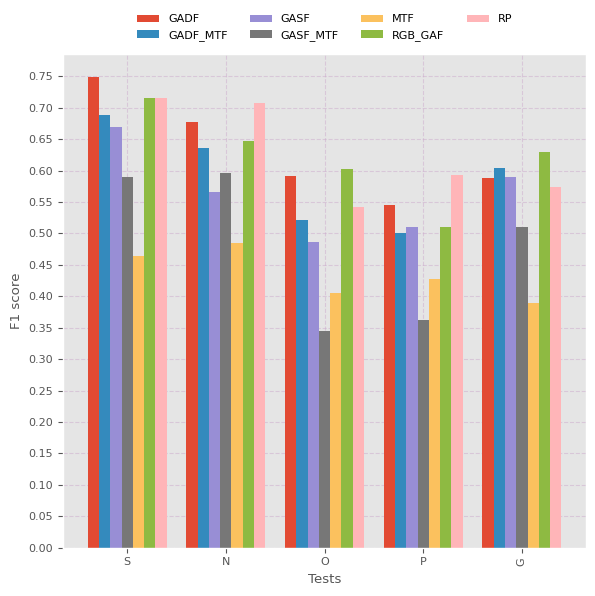

In [234]:
# t = []
# for test in list("SNOPG"):
#     fig, (ax1) = plt.subplots(1,1, tight_layout=True, figsize=(6, 5))
#     t1 = plotGategoriesResults(df1[(df1["experiment"] == "usedAlg effect") & (df1["Tests"]==test)], ["avgF1"], "imgAlg",  DIMS = (4,2), width = 0.9, shiftLegend = (0.5, 1.2), ax = ax1)
# #     fig.savefig(f"results/alg_impact_f1_{test}.png", dpi=300, format='png', bbox_inches='tight')
#     t1 = t1.rename(columns= {"avgF1":f"avgF1_{test}", "imgAlg":f"imgAlg_{test}"})
#     t.append(t1.reset_index())

# res1  = pd.concat(t, axis = 1)
# res1 = res1.drop(["index"], axis = 1)
# res1.to_csv("Results/alg_impact_f1.csv")

t = []
for test in list("SNOPG"):
    fig, (ax1) = plt.subplots(1,1, tight_layout=True, figsize=(6, 5))
    t1 = plotGategoriesResults(df[(df["experiment"] == "usedAlg effect") & (df["Tests"]==test)], ["Acc"], "imgAlg",  DIMS = (4,2), width = 0.9, shiftLegend = (0.5, 1.2), ax = ax1)
#     fig.savefig(f"results/alg_impact_acc_{test}.png", dpi=300, format='png', bbox_inches='tight')
    t1 = t1.rename(columns= {"Acc":f"Acc_{test}", "imgAlg":f"imgAlg_{test}"})
    t.append(t1.reset_index())

t0  = pd.concat(t, axis = 1)
t0 = t0.drop(["index"], axis = 1)
t0.to_csv("Results/alg_impact_acc.csv")

algs_name = sorted(t0["imgAlg_S"], key = lambda x:x)
res = {}
for c in ["imgAlg_S", "imgAlg_N", "imgAlg_O", "imgAlg_P", "imgAlg_G"]:
    l = list(zip(t0[c], t0["Acc_"+c.split("_")[-1]]))
    sor_l = sorted(l, key=lambda x:x[0])
    res[c] = list(zip(*sor_l))[1]

fig, ax = plt.subplots(1,1, figsize=(6,6), tight_layout=True)
d = pd.DataFrame(res, index = algs_name).T
groups = d.index
groups = [g.split("_")[1] for g in groups]
d.plot(kind = "bar", ax = ax, width = 0.8)
# ax.set_xticks(groups)
plt.xticks(range(0,len(groups)), groups, rotation=0)
ax.legend(loc='upper center', bbox_to_anchor = (0.5,1.1), ncol=4, fancybox=True, shadow=True, framealpha = 1, frameon = False)
ax.set_xlabel('Tests');
ax.set_ylabel('F1 score');
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.grid(which='major', color='#CCAACC', linestyle='--', alpha=0.5)
ax.grid(which='minor', color='#CCCC', linestyle=':', alpha=0.5)
fig.savefig("Results/alg_impact_acc.png")
# for bars in ax.containers:
#     ax.bar_label(bars, padding = 6, fontsize=7)

In [217]:
# # data from https://allisonhorst.github.io/palmerpenguins/

# import matplotlib.pyplot as plt
# import numpy as np

# species = ("Adelie", "Chinstrap", "Gentoo")
# penguin_means = {
#     'Bill Depth': (1, 18.43, 14.98),
#     'Bill Length': (2, 48.83, 47.50),
#     'Flipper Length': (3, 195.82, 217.19),
# }

# x = np.arange(len(species))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

# for attribute, measurement in penguin_means.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

# plt.show()

In [137]:
fig, (ax1) = plt.subplots(1,1, tight_layout=True, figsize=(6, 3))
t1 = plotGategoriesResults(df1[df1["experiment"] == "batch size"][0:7], ["Acc"], "batch_size", DIMS = (4,2), width = 0.9, shiftLegend = (0.5, 1.2), ax = ax1)
fig.savefig(f"results/bs_impact.png", dpi=300, format='png', bbox_inches='tight')
# t1.to_csv("results/bs_impact.csv")

fig, (ax1) = plt.subplots(1,1, tight_layout=True, figsize=(6, 4))
t2 = plotGategoriesResults(df[df["experiment"] == "image size"], ["avgF1"], "SIZE",  DIMS = (3,2), width = 0.9, shiftLegend = (0.5, 1.15), ax = ax1)
fig.savefig(f"results/is_impact.png", dpi=300, format='png', bbox_inches='tight')
# t2.to_csv("results/is_impact.csv")

t3 = plotGategoriesResults(df[df["experiment"] == "test effect"], ["Acc"], "Tests", DIMS = (5,10), width = 0.9, shiftLegend = (0.5, 1.1))
# t3.plot(kind="bar", x = "Tests", width = 0.8)
# plt.title("The impact of time aeries imagining algorithm")
# plt.xticks(rotation=90, ha='right')
# plt.xlabel("Conducted tests")
# plt.ylabel("Categorical accuracy")
# plt.savefig("results/tests_impact.png")
# t3.to_csv("results/tests_impact.csv")

t0 = t0.reset_index()
t1 = t1.reset_index()
t2 = t2.reset_index()
t3 = t3.reset_index()

total = pd.concat([t1, t2, t3], axis = 1)
total = total.drop(["index"], axis = 1)
total.to_csv("results/is_bs_Tests.csv")

In [138]:
right_parts = []
for test in list("SNOPG"):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(11, 4))
#     fig.suptitle(f"Left eye's features for  {test}")
    t1 = plotGategoriesResults(df1[(df1["experiment"] == "featuresbasedtest effect") &  ~df1['features'].str.startswith('_') & (df1["Tests"] == test)], ["F1:c0"], "features", DIMS = (2,2), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax1)
    t2 = plotGategoriesResults(df1[(df1["experiment"] == "featuresbasedtest effect") &  ~df1['features'].str.startswith('_') & (df1["Tests"] == test)], ["F1:c1"], "features", DIMS = (2,2), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax2)
    t3 = plotGategoriesResults(df1[(df1["experiment"] == "featuresbasedtest effect") &  ~df1['features'].str.startswith('_') & (df1["Tests"] == test)], ["F1:c2"], "features", DIMS = (2,2), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax3)
    t4 = plotGategoriesResults(df1[(df1["experiment"] == "featuresbasedtest effect") &  ~df1['features'].str.startswith('_') & (df1["Tests"] == test)], ["avgF1"], "features", DIMS = (2,2), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax3)
    ax2.set_ylabel(""), ax3.set_ylabel("")#, ax4.set_ylabel("")
#     fig.savefig(f"results/FeaturesBasedTest_{test}_right_compare.png", dpi=300, format='png', bbox_inches='tight')
    
    t1 = t1.rename(columns= {"features":f"{test}0", "F1:c0":f"F1{test}0",})
    t2 = t2.rename(columns= {"features":f"{test}1", "F1:c1":f"F1{test}1"})
    t3 = t3.rename(columns= {"features":f"{test}2", "F1:c2":f"F1{test}2"})
    t4 = t4.rename(columns= {"features":f"{test}", "avgF1":f"F1{test}"})
    
    res  = pd.concat([t1.reset_index(), t2.reset_index(), t3.reset_index(), t4.reset_index()], axis = 1)
    res = res.drop(["index"], axis = 1)
    res = res[[f"{test}0", f"F1{test}",
               f"{test}1", f"F1{test}",
               f"{test}2", f"F1{test}",
               f"{test}", f"F1{test}"]]
    res[[f"{test}", f"F1{test}"]].to_csv(f"results/FeaturesBasedTest_{test}_right_compare.csv", index = False)
    right_parts.append(f"results/FeaturesBasedTest_{test}_right_compare.csv")

left_parts = []   
for test in list("SNOPG"):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(11, 5))
    #     fig.suptitle(f"Right eye's features for  {test}")
    t1 = plotGategoriesResults(df1[(df1["experiment"] == "featuresbasedtest effect") &  df1['features'].str.startswith('_') & (df1["Tests"] == test)], ["F1:c0"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax1)
    t2 = plotGategoriesResults(df1[(df1["experiment"] == "featuresbasedtest effect") &  df1['features'].str.startswith('_') & (df1["Tests"] == test)], ["F1:c1"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax2)
    t3 = plotGategoriesResults(df1[(df1["experiment"] == "featuresbasedtest effect") &  df1['features'].str.startswith('_') & (df1["Tests"] == test)], ["F1:c2"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax3)
    t4 = plotGategoriesResults(df1[(df1["experiment"] == "featuresbasedtest effect") &  df1['features'].str.startswith('_') & (df1["Tests"] == test)], ["avgF1"], "features", DIMS = (2,2), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax3)

    ax2.set_ylabel(""), ax3.set_ylabel("")#, ax4.set_ylabel("")
#     fig.savefig(f"results/FeaturesBasedTest_{test}_left_compare.png", dpi=300, format='png', bbox_inches='tight')

    t1 = t1.rename(columns= {"features":f"{test}0", "F1:c0":f"F1{test}0",})
    t2 = t2.rename(columns= {"features":f"{test}1", "F1:c1":f"F1{test}1"})
    t3 = t3.rename(columns= {"features":f"{test}2", "F1:c2":f"F1{test}2"})
    t4 = t4.rename(columns= {"features":f"{test}", "avgF1":f"F1{test}"})

    res  = pd.concat([t1.reset_index(), t2.reset_index(), t3.reset_index(), t4.reset_index()], axis = 1)
    res = res.drop(["index"], axis = 1)
    res = res[[f"{test}0", f"F1{test}0",
               f"{test}1", f"F1{test}1",
               f"{test}2", f"F1{test}2",
               f"{test}", f"F1{test}"]]
    res[f"{test}0"] =res[f"{test}0"].apply(lambda x: x[1:])
    res[f"{test}1"] =res[f"{test}1"].apply(lambda x: x[1:])
    res[f"{test}2"] =res[f"{test}2"].apply(lambda x: x[1:])
    res[f"{test}"] =res[f"{test}"].apply(lambda x: x[1:])

    res[[f"{test}", f"F1{test}"]].to_csv(f"results/FeaturesBasedTest_{test}_left_compare.csv", index = False)
    left_parts.append(f"results/FeaturesBasedTest_{test}_left_compare.csv")
    
    
df11 = pd.DataFrame()
df22 = pd.DataFrame()

for fl, fr in zip(left_parts, right_parts):
    tl = pd.read_csv(fl)
    tr = pd.read_csv(fr)
    t1 = t1.rename(columns = {"F1:c0":"F1:c0"})
    df11 = pd.concat((df11, tl), axis = 1)
    df22 = pd.concat((df22, tr), axis = 1)

df11.to_csv("results/left.csv", index = False)
df22.to_csv("results/right.csv", index = False)


In [63]:
# t = []
# methods = ["GADF", "GASF", "RGB_GAF", "MTF", "RP", "GASF_MTF","GADF_MTF"]
# for alg in methods:
#     fig, (ax1) = plt.subplots(1,1, tight_layout=True, figsize=(6, 5))
#     t1 = plotGategoriesResults(df[(df["experiment"] == "image size") & (df["imgAlg"]==alg)], ["avgF1"], "imgAlg",  DIMS = (4,2), width = 0.9, shiftLegend = (0.5, 1.2), ax = ax1)
# #     fig.savefig(f"results/alg_{test}.png", dpi=300, format='png', bbox_inches='tight')
#     t1 = t1.rename(columns= {"avgF1":f"avgF1_{test}", "SIZE":f"SIZE_{test}"})
#     t.append(t1.reset_index())

# res  = pd.concat(t, axis = 1)
# res = res.drop(["index"], axis = 1)
# res.to_csv("Results/alg_impact.csv")

In [112]:
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, tight_layout=True, figsize=(12, 4))
# t1 = plotGategoriesResults(df[df["experiment"] == "test effect"], ["F1:c0"], "Tests", DIMS = (3,4), width = 0.9, shiftLegend = (0.5, 1.1), ax = ax1)
# t2 = plotGategoriesResults(df[df["experiment"] == "test effect"], ["F1:c1"], "Tests", DIMS = (3,4), width = 0.9, shiftLegend = (0.5, 1.1), ax = ax2)
# t3 = plotGategoriesResults(df[df["experiment"] == "test effect"], ["F1:c2"], "Tests", DIMS = (3,4), width = 0.9, shiftLegend = (0.5, 1.1), ax = ax3)
# t4 = plotGategoriesResults(df[df["experiment"] == "test effect"], ["avgF1"], "Tests", DIMS = (3,4), width = 0.9, shiftLegend = (0.5, 1.1), ax = ax4)
# # fig.suptitle(f"xxx")
# ax2.set_ylabel(""), ax3.set_ylabel(""), ax4.set_ylabel("")
# fig.savefig(f"results/Tests_compare.png", dpi=300, format='png', bbox_inches='tight')



In [65]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(11, 5))
# plotGategoriesResults(df[(df["experiment"] == "features effect") &  ~df['features'].str.startswith('_')], ["F1:c0"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax1)
# plotGategoriesResults(df[(df["experiment"] == "features effect") &  ~df['features'].str.startswith('_')], ["F1:c1"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax2)
# plotGategoriesResults(df[(df["experiment"] == "features effect") &  ~df['features'].str.startswith('_')], ["F1:c2"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax3)
# # plotGategoriesResults(df[(df["experiment"] == "features effect") &  ~df['features'].str.startswith('_')], ["avgF1"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.1), ax = ax4)
# # fig.suptitle(f"Features_compare_right")
# ax2.set_ylabel(""), ax3.set_ylabel(""), ax4.set_ylabel("")
# fig.savefig(f"results/Features_compare_right.png", dpi=300, format='png', bbox_inches='tight')

# fig, (ax1, ax2, ax3) = plt.subplots(1,3, tight_layout=True, figsize=(11, 5))
# plotGategoriesResults(df[(df["experiment"] == "features effect") &  df['features'].str.startswith('_')], ["F1:c0"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax1)
# plotGategoriesResults(df[(df["experiment"] == "features effect") &  df['features'].str.startswith('_')], ["F1:c1"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax2)
# plotGategoriesResults(df[(df["experiment"] == "features effect") &  df['features'].str.startswith('_')], ["F1:c2"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.05), ax = ax3)
# # plotGategoriesResults(df[(df["experiment"] == "features effect") &  ~df['features'].str.startswith('_')], ["avgF1"], "features", DIMS = (2,3), width = 0.9, shiftLegend = (0.5, 1.1), ax = ax4)
# # fig.suptitle(f"Features_compare_left")
# ax2.set_ylabel(""), ax3.set_ylabel(""), ax4.set_ylabel("")

# fig.savefig(f"results/Features_compare_left.png", dpi=300, format='png', bbox_inches='tight')

In [67]:
# res1 = res[["Acc_S", "Acc_N", "Acc_O", "Acc_P", "Acc_G"]]

In [68]:
# res.plot(kind="bar", width = 0.8)
# # plt.title("The impact of time aeries imagining algorithm")
# plt.xticks(rotation=45, ha='right')
# plt.xlabel("TSI algorithm")
# plt.ylabel("Categorical accuracy")
# plt.savefig("results/tsi_impact.png")

In [70]:

# best_left = pd.DataFrame(df1.iloc[0].values.reshape(5, -1), index = list('SNOPG'))
# best_right = pd.DataFrame(df2.iloc[0].values.reshape(5, -1), index = list('SNOPG'))

# best_left = best_left.rename(columns = {0:"class0", 1:"",  2:"class1", 3:"", 4:"class2", 5:""})
# best_right = best_right.rename(columns = {0:"class0", 1:"",  2:"class1", 3:"", 4:"class2", 5:""})
# best_fearures_for_tests_both_eyes = pd.concat((best_left, best_right), axis = 1)
# best_fearures_for_tests_both_eyes.to_csv("results/best_fearures_for_tests_both_eyes.csv")
# best_fearures_for_tests_both_eyes

In [57]:
# df11 = df1[::-1]

# fig, ax = plt.subplots(3,2, tight_layout=True, figsize=(10, 14))
# axx = ax.flat
# # df1[::-1].plot(x = "S", y = ["F1S0", "F1S1", "F1S2", "F1S"], kind = "barh", stacked = True, width = 0.9, ax = ax)

# df11.plot(x = "S", y = ["F1S0", "F1S1", "F1S2", "F1S"], kind = "bar", stacked = True, width = 0.9, ax = axx[0])
# df11.plot(x = "N", y = ["F1N0", "F1N1", "F1N2", "F1N"], kind = "bar", stacked = True, width = 0.9, ax = axx[1])
# df11.plot(x = "O", y = ["F1O0", "F1O1", "F1O2", "F1O"], kind = "bar", stacked = True, width = 0.9, ax = axx[2])
# df11.plot(x = "P", y = ["F1P0", "F1P1", "F1P2", "F1P"], kind = "bar", stacked = True, width = 0.9, ax = axx[3])
# df11.plot(x = "G", y = ["F1G0", "F1G1", "F1G2", "F1G"], kind = "bar", stacked = True, width = 0.9, ax = axx[4])

# # fig.delaxes(axx[-1])

# for ax_tmp in axx:
#     for bars in ax_tmp.containers:
#         ax_tmp.bar_label(bars, padding = 6, fontsize=7)

In [53]:
df1.columns

Index(['loss', 'Acc', 'precision', 'recall', 'prc', 'precision0', 'precision1',
       'precision2', 'recall0', 'recall1', 'recall2', 'F1:c0', 'F1:c1',
       'F1:c2', 'model_arch', 'model_name', 'Epochs', 'lr', 'batch_size',
       'SIZE', 'Tests', 'features', 'imgAlg', 'experiment', 'avgF1'],
      dtype='object')

In [61]:
vvv = df1[df1["Epochs"] == 1000][["Acc", "model_name"]]
vvv

,Acc,model_name
883,0.8148,N__XAJ_left_model_09_03_2023_18_46_01_rowId1
884,0.8462,O__AJ_left_model_09_03_2023_19_54_49_rowId2
885,0.7816,G__AJ_left_model_09_03_2023_23_15_12_rowId4
886,0.7857,S_AJ_right_model_10_03_2023_02_54_49_rowId5
887,0.6111,N_YJ_right_model_10_03_2023_04_39_01_rowId6
888,0.7692,O_AJ_right_model_10_03_2023_05_25_24_rowId7
889,0.6667,G_A_right_model_10_03_2023_11_00_46_rowId9
892,0.7381,S__XAJ_left_model_10_03_2023_19_34_06_rowId0
893,0.6111,P__AJ_left_model_11_03_2023_05_03_19_rowId1
894,0.6792,P_YAJ_right_model_11_03_2023_21_39_44_rowId0


In [62]:
def gett(x):    
    res = x.split("_")
    if res[1] != "":
        return res[1]
    else:
        return res[2]
    
def gett1(x):
    
    res = x.split("_")
    if res[1] != "":
        return "right"
    else:
        return "left"
vvv["test"]  = vvv["model_name"].apply(lambda x: x.split("_")[0])
vvv["features"]  = vvv["model_name"].apply(gett)
vvv["eye"]  = vvv["model_name"].apply(gett1)


In [63]:
vvv

,Acc,model_name,test,features,eye
883,0.8148,N__XAJ_left_model_09_03_2023_18_46_01_rowId1,N,XAJ,left
884,0.8462,O__AJ_left_model_09_03_2023_19_54_49_rowId2,O,AJ,left
885,0.7816,G__AJ_left_model_09_03_2023_23_15_12_rowId4,G,AJ,left
886,0.7857,S_AJ_right_model_10_03_2023_02_54_49_rowId5,S,AJ,right
887,0.6111,N_YJ_right_model_10_03_2023_04_39_01_rowId6,N,YJ,right
888,0.7692,O_AJ_right_model_10_03_2023_05_25_24_rowId7,O,AJ,right
889,0.6667,G_A_right_model_10_03_2023_11_00_46_rowId9,G,A,right
892,0.7381,S__XAJ_left_model_10_03_2023_19_34_06_rowId0,S,XAJ,left
893,0.6111,P__AJ_left_model_11_03_2023_05_03_19_rowId1,P,AJ,left
894,0.6792,P_YAJ_right_model_11_03_2023_21_39_44_rowId0,P,YAJ,right


In [64]:
last = vvv[["test", "features", "Acc"]]
last.to_csv("results/last_res.csv")

In [65]:
last

,test,features,Acc
883,N,XAJ,0.8148
884,O,AJ,0.8462
885,G,AJ,0.7816
886,S,AJ,0.7857
887,N,YJ,0.6111
888,O,AJ,0.7692
889,G,A,0.6667
892,S,XAJ,0.7381
893,P,AJ,0.6111
894,P,YAJ,0.6792


In [105]:
cccc = df1[(df1["experiment"] == "featuresbasedtest effect") &  df['features'].str.startswith('_') & (df["Tests"] == "G")]
cccc[cccc["features"] == "_XJN"]

C:\Users\Moham\AppData\Local\Temp\ipykernel_9316\3381941973.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cccc = df1[(df1["experiment"] == "featuresbasedtest effect") &  df['features'].str.startswith('_') & (df["Tests"] == "G")]


,loss,Acc,precision,recall,prc,precision0,precision1,precision2,recall0,recall1,...,S,F1S,N,F1N,O,F1O,P,F1P,G,F1G
892,1.1509,0.4656,0.4659,0.313,0.4524,0.6667,0.125,0.5714,0.1887,0.3333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


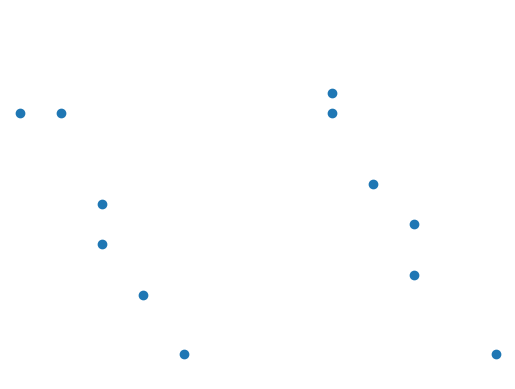

In [4]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(ncols=2,nrows=3, sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.scatter([i//2+1, i],[i,i//3])
    ax.axis('off')
plt.show()